In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

In [3]:
data_path = Path("../data/quora/")

In [4]:
data_path.ls()

[PosixPath('../data/quora/train.csv'),
 PosixPath('../data/quora/sample_submission.csv'),
 PosixPath('../data/quora/embeddings'),
 PosixPath('../data/quora/test.csv')]

In [5]:
train_df = pd.read_csv(data_path/"train.csv")
test_df = pd.read_csv(data_path/"test.csv")

In [6]:
train_df.head(2)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0


In [7]:
test_df.head(2)

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?


In [8]:
test_df['target'] = 0

In [9]:
# concat all data for language modeling
text_df = pd.concat([train_df, test_df])

In [10]:
train_df.shape, test_df.shape, text_df.shape

((1306122, 3), (56370, 3), (1362492, 3))

### Fine tuning language model

In [11]:
data_lm = (TextList.from_df(df=text_df, path='.', cols="question_text")
               .random_split_by_pct(0.05)
               .label_for_lm()
               .databunch())

In [12]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103_1, drop_mult=0.5)

In [19]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [14]:
learn.validate(learn.data.valid_dl)

[5.951782, tensor(0.1553)]

In [22]:
learn.fit_one_cycle(1, 5e-2)

epoch,train_loss,valid_loss,accuracy
1,4.199656,3.953942,0.351583


In [35]:
learn.predict("Am I actually", n_words=10)

'Am I actually going with biotechnology after anyone joined to multiple subjects ?'

In [37]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,3.648641,3.535505,0.391344


In [39]:
learn.predict("How would a data scientist", n_words=10)

'How would a data scientist be employed in as a fresher electrical engineer ? xxbos'

In [41]:
learn.save_encoder("ft_enc")

In [79]:
data_lm.save()

In [ ]:
data_lm.load()

In [34]:
model_dict = get_model(learn.model).state_dict()

In [44]:
encoder_state = get_model(learn.model)[0].state_dict()

In [50]:
k,v = zip(*list(encoder_state.items()))

In [78]:
k

('encoder.weight',
 'encoder_dp.emb.weight',
 'rnns.0.weight_hh_l0_raw',
 'rnns.0.module.weight_ih_l0',
 'rnns.0.module.weight_hh_l0',
 'rnns.0.module.bias_ih_l0',
 'rnns.0.module.bias_hh_l0',
 'rnns.1.weight_hh_l0_raw',
 'rnns.1.module.weight_ih_l0',
 'rnns.1.module.weight_hh_l0',
 'rnns.1.module.bias_ih_l0',
 'rnns.1.module.bias_hh_l0',
 'rnns.2.weight_hh_l0_raw',
 'rnns.2.module.weight_ih_l0',
 'rnns.2.module.weight_hh_l0',
 'rnns.2.module.bias_ih_l0',
 'rnns.2.module.bias_hh_l0')

In [102]:
v

(tensor([[ 0.1519,  0.0584, -0.2037,  ..., -0.0608, -0.0194, -0.2690],
         [ 0.2069, -0.0384,  0.1234,  ..., -0.0258, -0.0756, -0.1575],
         [-0.9274,  0.0241,  0.1056,  ..., -0.1405, -0.1731,  0.0738],
         ...,
         [ 0.0925,  0.0680, -0.0463,  ..., -0.0311,  0.0464, -0.1263],
         [ 0.2356, -0.0249,  0.1637,  ..., -0.0054, -0.0643, -0.1600],
         [ 0.2161, -0.1127,  0.2594,  ..., -0.0484, -0.0795, -0.1250]],
        device='cuda:0'),
 tensor([[ 0.1519,  0.0584, -0.2037,  ..., -0.0608, -0.0194, -0.2690],
         [ 0.2069, -0.0384,  0.1234,  ..., -0.0258, -0.0756, -0.1575],
         [-0.9274,  0.0241,  0.1056,  ..., -0.1405, -0.1731,  0.0738],
         ...,
         [ 0.0925,  0.0680, -0.0463,  ..., -0.0311,  0.0464, -0.1263],
         [ 0.2356, -0.0249,  0.1637,  ..., -0.0054, -0.0643, -0.1600],
         [ 0.2161, -0.1127,  0.2594,  ..., -0.0484, -0.0795, -0.1250]],
        device='cuda:0'),
 tensor([[-0.1827, -0.2548, -0.1800,  ...,  0.0278,  0.2986,  0.00

In [80]:
val = (to_np(v[0]).astype(np.float16))

In [83]:
val.shape

(60003, 400)

In [87]:
binary = pickle.dumps(val)

In [94]:
compressed = zlib.compress(binary, 9)

In [96]:
len(binary)

48002562

In [97]:
encoded = base64.b64encode((compressed))

In [98]:
len(encoded)

36609736

### Classification Model

In [11]:
class fbeta_binary(Callback):
    "Computes the f_beta between preds and targets for binary text classification"

    def __init__(self, beta2 = 1, eps=1e-9, sigmoid = True):      
        self.beta2=beta2**2
        self.eps = eps
        self.sigmoid = sigmoid
    
    def on_epoch_begin(self, **kwargs):
        self.TP = 0
        self.total_y_pred = 0   
        self.total_y_true = 0
    
    def on_batch_end(self, last_output, last_target, **kwargs):
        y_pred = last_output
        y_pred = y_pred.softmax(dim = 1)        
        y_pred = y_pred.argmax(dim=1)
        y_true = last_target.float()
        
        self.TP += ((y_pred==1) * (y_true==1)).float().sum()
        self.total_y_pred += (y_pred==1).float().sum()
        self.total_y_true += (y_true==1).float().sum()
    
    def on_epoch_end(self, **kwargs):
        prec = self.TP/(self.total_y_pred+self.eps)
        rec = self.TP/(self.total_y_true+self.eps)
        res = (prec*rec)/(prec*self.beta2+rec+self.eps)*(1+self.beta2)        
        self.metric = res     

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, eps=1e-7, c=2):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps
        self.c = c
        
    def forward(self, input, target):       
        mask = torch.eye(self.c)[target]
        probas = torch.softmax(input, dim=1)
        probas = probas.clamp(self.eps, 1. - self.eps)
        pt = torch.masked_select(probas, mask.byte().cuda())
        return torch.mean(-torch.pow((1-pt), self.gamma)*torch.log(pt))

In [404]:
# create train, valid and test
train_df.head(2)

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0


In [405]:
test_df.head(2)

,qid,question_text,target
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...,0
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?,0


In [406]:
# create train-val split
np.random.seed(42)
shuffled_idxs = np.random.permutation(range(len(train_df)))
n_valid = int(len(train_df)*0.05)
valid_idxs, train_idxs = shuffled_idxs[:n_valid], shuffled_idxs[n_valid:]
trn_df = train_df.iloc[train_idxs].reset_index(drop=True)
val_df = train_df.iloc[valid_idxs].reset_index(drop=True)

print(trn_df.target.value_counts(True))
print(val_df.target.value_counts(True))

0    0.93805
1    0.06195
Name: target, dtype: float64
0    0.939638
1    0.060362
Name: target, dtype: float64


In [407]:
data_clas = TextClasDataBunch.from_df(".", train_df=trn_df, valid_df=val_df, test_df=test_df,
                                      text_cols="question_text", label_cols="target",
                                      vocab=data_lm.train_ds.vocab, bs=512)

In [444]:
data_clas.save()

### Training

In [26]:
# load existing databunch
data_clas = TextClasDataBunch.load(".", bs=512)
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('ft_enc');

In [27]:
fbeta = fbeta_binary()
learn.metrics = [accuracy, fbeta]
focal_loss = FocalLoss(gamma=2)
learn.loss_func = focal_loss

In [434]:
# stage-1 training
learn.freeze_to(-2)
learn.fit_one_cycle(10, 1e-2)

In [28]:
# learn.save("clas-stage-1")
learn.load("clas-stage-1");

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


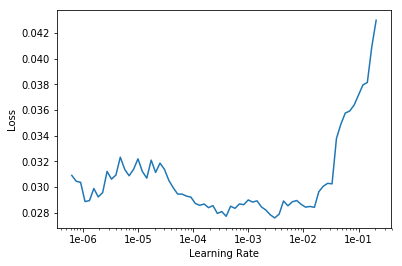

In [29]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [ ]:
# stage-2 trainin
learn.fit_one_cycle(10, slice(1e-4))

In [31]:
learn.save("clas-stage-2")
learn.load("clas-stage-2");

### Tune Threshold 

Since `SortSampler` is used validation and test data is also doesn't have the original order

In [37]:
from sklearn.metrics import f1_score

In [32]:
lengths = [len(t) for t in learn.data.valid_ds.x.items]
sampler = SortSampler(range(len(learn.data.valid_ds.x)), key=lengths.__getitem__)
idxs = [i for i in sampler]

In [33]:
pred_out = learn.get_preds(ds_type=DatasetType.Valid)

In [48]:
preds = to_np(torch.softmax(pred_out[0], dim=1)[:, 1])

In [49]:
sorted_preds = preds[np.argsort(idxs)]

In [52]:
sorted_preds.min(), sorted_preds.max()

(2.0120552e-32, 0.9939008)

In [53]:
actual = learn.data.valid_ds.y.items

In [56]:
best_score, best_thresh = 0,0
for t in np.linspace(0.01, 0.99, 50):
    score = f1_score(actual, sorted_preds > t)
    if score > best_score:
        best_score = score
        best_thresh = t
    print(score, t)
print()
print(best_score, best_thresh)

0.1171621581406422 0.01
0.12482755339898197 0.03
0.14211363307792393 0.05
0.17161961367013373 0.06999999999999999
0.2125635380140803 0.09
0.26029962546816476 0.11
0.3072396930783604 0.13
0.35291954022988503 0.15000000000000002
0.39407898141918124 0.17
0.4323209169054441 0.19
0.46532187772382017 0.21000000000000002
0.495330242558624 0.23
0.5232959447799826 0.25
0.5489172170173553 0.27
0.5696377696377696 0.29000000000000004
0.5922221264120031 0.31
0.610535876475931 0.33
0.6260620525059666 0.35000000000000003
0.6380158650466915 0.37
0.6488188976377953 0.39
0.6561264822134387 0.41000000000000003
0.6576689923367265 0.43
0.6604046242774567 0.45
0.6569672645177473 0.47000000000000003
0.6442635862431084 0.49
0.6317089910775566 0.51
0.6150742181870585 0.53
0.5940235436160579 0.55
0.5583095011121703 0.5700000000000001
0.5138140161725068 0.59
0.45516744688512784 0.61
0.3937942922811722 0.63
0.3208009807928075 0.65
0.2566523605150215 0.67
0.19605204127411394 0.6900000000000001
0.1554069633387134 0

### Prepare Submission

Since `SortSampler` is used validation and test data is also doesn't have the original order

In [57]:
lengths = [len(t) for t in learn.data.test_ds.x.items]
sampler = SortSampler(range(len(learn.data.test_ds.x)), key=lengths.__getitem__)
idxs = [i for i in sampler]

In [63]:
pred_out = learn.get_preds(ds_type=DatasetType.Test)
preds = to_np(torch.softmax(pred_out[0], dim=1)[:, 1] > best_thresh)
sorted_preds = preds[np.argsort(idxs)]
pred_str = ''.join([str(i) for i in sorted_preds.tolist()])

In [65]:
pred_str

'000000000000000000000000000000000000000100000000000000100000000000000000000001000000000000000000001000100100000000000100000100000000101001000000000011000000000000001010000110000000000000100000000000100000000000100000010100100000000000000000000001000111000000000000000000000000000000001000001000000100010000010000000000000000000000000000000100100100000000000000000000000000000000001000010000001000000000100000000001000100000000000001010000000000000000010000000000000100010000000000000000000000000000000000000000010100000000000000100001000000000000001000000010010000000000000010000000000000000000000000000000000000010000000000000000000000000000100000000000000000000000000000100000000000000000001000000000001000000000000000000000000001000010000000000010000100000000000000000000000100000000000000000000000000000010000000000000000000000000000000000000001000100000001000000000000000000000000000000000000000000000000000000100000000000000000010000000000000001000000000000000000000000000000000011000000000000

### CV-LB

In [66]:
CV_LB_T = [0.6604046242774567, 0.654, 0.45]